# # LLaVA Answer
## ## Only-Mask Token

In [1]:
import torch
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

TOK_FILE  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/006_siglip_tokens.pt")
MODEL_ID  = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV       = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE     = torch.bfloat16   

In [ ]:
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model     = LlavaOnevisionForConditionalGeneration.from_pretrained(
               MODEL_ID,
               torch_dtype       = DTYPE,
               low_cpu_mem_usage = True,
               device_map        = "auto",
               trust_remote_code = True,
           ).eval()

In [3]:
saved  = torch.load(TOK_FILE, map_location="cpu", weights_only=False)
mask_token = saved["mask_token"]                    
mask_token = mask_token.to(DEV, DTYPE).unsqueeze(0) 

with torch.no_grad():
    mask_embeds = model.multi_modal_projector(mask_token)  

mask_attn = torch.ones(mask_embeds.size()[:2], dtype=torch.long, device=DEV)  

prompt = "<image> " * mask_embeds.size(1) + "Is there any anomaly in the image?.\n### Assistant:"
tok = processor.tokenizer(prompt, return_tensors="pt").to(DEV)

text_embeds = model.get_input_embeddings()(tok.input_ids)   
text_mask   = tok.attention_mask                           

inputs_embeds  = torch.cat([mask_embeds, text_embeds], dim=1)   
attention_mask = torch.cat([mask_attn,   text_mask],   dim=1)   

with torch.no_grad():
    gen_ids = model.generate(
        inputs_embeds   = inputs_embeds,
        attention_mask  = attention_mask,
        max_new_tokens  = 100,
        do_sample       = False,
        eos_token_id    = processor.tokenizer.eos_token_id,
        pad_token_id    = processor.tokenizer.eos_token_id,
    )

answer = processor.tokenizer.decode(gen_ids[0], skip_special_tokens=True)
print("\n=== LLaVA Answer ===\n", answer)


=== LLaVA Answer ===
 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


## ## Global Token 추가

In [ ]:
import torch
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

ROOT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole")
MASK = ROOT
GLOB = ROOT / "good"
MODEL = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV   = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16

proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
          MODEL, torch_dtype=DTYPE, device_map="auto",
          low_cpu_mem_usage=True, trust_remote_code=True).eval()
tok_img = proc.tokenizer.additional_special_tokens[0]          

In [3]:
for i in range(18):
    stem = f"{i:03d}"
    f_mask = MASK / f"{stem}_siglip_tokens.pt"
    f_glo  = GLOB / f"{stem}_global_token.pt"
    if not (f_mask.exists() and f_glo.exists()):
        print(f"[{stem}]  ⨯ token missing"); continue

    d   = torch.load(f_mask, map_location="cpu", weights_only=False)
    g   = torch.load(f_glo,  map_location="cpu", weights_only=False)["global_token"]
    tok = torch.cat([g.unsqueeze(0), d["mask_token"]], dim=0).to(DEV, DTYPE)  
    with torch.no_grad():
        v_emb = llava.multi_modal_projector(tok.unsqueeze(0))                 

    N = v_emb.size(1)
    user_prompt = "USER: Is there any anomaly in the image? (Yes / No)\nASSISTANT:"
    prompt = (tok_img + " ") * N + user_prompt      
    tok_in = proc.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb  = llava.get_input_embeddings()(tok_in.input_ids).to(DTYPE)
    att_img = torch.ones(1, N, dtype=torch.long, device=DEV)

    inp      = torch.cat([v_emb, t_emb], dim=1)
    att_mask = torch.cat([att_img, tok_in.attention_mask], dim=1)

    with torch.no_grad():
        gen = llava.generate(
                inputs_embeds=inp, attention_mask=att_mask,
                max_new_tokens=30, temperature=0.7, do_sample=False,
                eos_token_id=proc.tokenizer.eos_token_id,
                pad_token_id=proc.tokenizer.eos_token_id)
    ans = proc.tokenizer.decode(gen[0], skip_special_tokens=True).strip()
    print(f"[{stem}]  {ans}")

/opt/conda/envs/llava-token/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:636: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


[000]  No, there is no anomaly in the image.
[001]  No, there is no anomaly in the image.
[002]  No, there is no anomaly in the image.
[003]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[004]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[005]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[006]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[007]  No, there is no anomaly in the image.
[008]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[009]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[010]  No, there is no anomaly in the image.
[011]  No, there is no anomaly in the image.
[012]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[013]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[014]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[015]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[016]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[017]  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


# # LayerNorm 적용 후 Softmax & LLaVA Answer 확인

## ## Mask Token

In [1]:
import torch, torch.nn.functional as F
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/000_siglip_tokens.pt")
MODEL   = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEV     = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE   = torch.bfloat16

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
          MODEL, device_map="auto",
          torch_dtype=DTYPE, low_cpu_mem_usage=True,
          trust_remote_code=True).eval()
tok_img = proc.tokenizer.additional_special_tokens[0]

In [3]:
d   = torch.load(MASK_PT, map_location="cpu", weights_only=False)
tok = torch.nn.functional.layer_norm(d["mask_token"], d["mask_token"].shape[-1:])
tok = tok.to(DEV, DTYPE).unsqueeze(0)                                   

with torch.no_grad():
    v_emb = llava.multi_modal_projector(tok)                            

M = v_emb.size(1)
prompt = (tok_img + " ") * M + \
         "USER: Is there any anomaly in the image? Yes or No\nASSISTANT:"
ids  = proc.tokenizer(prompt, return_tensors="pt").to(DEV).input_ids
t_emb = llava.get_input_embeddings()(ids).to(DTYPE)
attn  = torch.ones(1, M, dtype=torch.long, device=DEV)

inp_emb = torch.cat([v_emb, t_emb], 1)
att_all = torch.cat([attn, ids.new_ones(ids.shape)], 1)

with torch.no_grad():
    out = llava(inputs_embeds=inp_emb, attention_mask=att_all, return_dict=True)
logits = out.logits[0, -1]
id_yes = proc.tokenizer(" Yes", add_special_tokens=False).input_ids[0]
id_no  = proc.tokenizer(" No",  add_special_tokens=False).input_ids[0]
p_yes, p_no = F.softmax(logits[[id_yes, id_no]], 0).tolist()
print(f"P(Yes)={p_yes:.3f}   P(No)={p_no:.3f}")

with torch.no_grad():
    gen = llava.generate(
            inputs_embeds   = inp_emb,
            attention_mask  = att_all,
            max_new_tokens  = 30,
            do_sample       = False,
            eos_token_id    = proc.tokenizer.eos_token_id,
            pad_token_id    = proc.tokenizer.eos_token_id)
ans = proc.tokenizer.decode(gen[0], skip_special_tokens=True).strip()
print("\n=== LLaVA Answer ===\n", ans)

P(Yes)=0.516   P(No)=0.484

=== LLaVA Answer ===
 Yes, there is an anomaly in the image.


## ## Global Token + Mask Token

In [3]:
import torch
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration
import torch.nn.functional as F

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/000_siglip_tokens.pt")
GLOB_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/good/000_global_token.pt")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"

DEV   = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
          MODEL_ID,
          device_map="auto",
          torch_dtype=DTYPE,
          low_cpu_mem_usage=True,
          trust_remote_code=True).eval()
tok_img = proc.tokenizer.additional_special_tokens[0]           

In [4]:
dat = torch.load(MASK_PT, map_location="cpu", weights_only=False)
mask_tok = dat["mask_token"]                                    

if GLOB_PT.exists():
    g = torch.load(GLOB_PT, map_location="cpu", weights_only=False)["global_token"]
    mask_tok = torch.cat([g.unsqueeze(0), mask_tok], dim=0)     

mask_tok = F.layer_norm(mask_tok, mask_tok.shape[-1:])          
mask_tok = mask_tok.to(DEV, DTYPE).unsqueeze(0)                

with torch.no_grad():
    vis_emb = llava.multi_modal_projector(mask_tok)            

T = vis_emb.size(1)                                            

prompt  = (tok_img + " ") * T + \
          "USER: Is there any anomaly in the image? Yes or No\nASSISTANT:"
ids     = proc.tokenizer(prompt, return_tensors="pt").to(DEV).input_ids
txt_emb = llava.get_input_embeddings()(ids).to(DTYPE)

attn_img = torch.ones(1, T, dtype=torch.long, device=DEV)       

inp_emb = torch.cat([vis_emb, txt_emb], dim=1)                  
attn_m  = torch.cat([attn_img, torch.ones_like(ids)], dim=1)

with torch.no_grad():
    out = llava(inputs_embeds=inp_emb,
                attention_mask=attn_m,
                return_dict=True)

logits_last = out.logits[0, -1]                                 
tid_yes = proc.tokenizer(" Yes", add_special_tokens=False).input_ids[0]
tid_no  = proc.tokenizer(" No",  add_special_tokens=False).input_ids[0]
p_yes, p_no = F.softmax(logits_last[[tid_yes, tid_no]], 0).tolist()

print(f"P(Yes) = {p_yes:.3f}   P(No) = {p_no:.3f}")

with torch.no_grad():
    gen_ids = llava.generate(
                inputs_embeds   = inp_emb,
                attention_mask  = attn_m,
                max_new_tokens  = 30,
                do_sample       = False,
                eos_token_id    = proc.tokenizer.eos_token_id,
                pad_token_id    = proc.tokenizer.eos_token_id)

answer = proc.tokenizer.decode(gen_ids[0], skip_special_tokens=True).strip()
print("\n=== LLaVA Answer ===\n", answer)

P(Yes) = 0.531   P(No) = 0.469

=== LLaVA Answer ===
 Yes, there is an anomaly in the image.


## ## 모든 이미지에 대한 LLaVA Answer 확인

In [1]:
import torch, torch.nn.functional as F
from pathlib import Path
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

BASE_DIR = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"

DEV   = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16

In [ ]:
proc  = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
llava = LlavaOnevisionForConditionalGeneration.from_pretrained(
          MODEL_ID,
          device_map="auto",
          torch_dtype=DTYPE,
          low_cpu_mem_usage=True,
          trust_remote_code=True).eval()
tok_img = proc.tokenizer.additional_special_tokens[0] 

tid_yes = proc.tokenizer(" Yes", add_special_tokens=False).input_ids[0]
tid_no  = proc.tokenizer(" No",  add_special_tokens=False).input_ids[0]

In [3]:
for i in range(18):
    stem = f"{i:03d}"
    mask_pt = BASE_DIR / f"{stem}_siglip_tokens.pt"
    glob_pt = BASE_DIR / "good" / f"{stem}_global_token.pt"
    if not mask_pt.exists():
        print(f"[{stem}]  ⨯ mask token 파일 없음"); continue

    dat = torch.load(mask_pt, map_location="cpu", weights_only=False)
    tok = dat["mask_token"]                                   
    if glob_pt.exists():
        g = torch.load(glob_pt, map_location="cpu", weights_only=False)["global_token"]
        tok = torch.cat([g.unsqueeze(0), tok], dim=0)         

    tok = F.layer_norm(tok, tok.shape[-1:]).to(DEV, DTYPE).unsqueeze(0) 
    with torch.no_grad():
        vis = llava.multi_modal_projector(tok)                           

    T = vis.size(1)
    prompt = (tok_img + " ") * T + \
             "USER: Is there any anomaly in the image? Yes or No\nASSISTANT:"
    ids  = proc.tokenizer(prompt, return_tensors="pt").to(DEV).input_ids
    txt  = llava.get_input_embeddings()(ids).to(DTYPE)
    attn = torch.ones(1, T, dtype=torch.long, device=DEV)

    inp  = torch.cat([vis, txt], 1)                       
    attm = torch.cat([attn, ids.new_ones(ids.shape)], 1)

    with torch.no_grad():
        out = llava(inputs_embeds=inp, attention_mask=attm, return_dict=True)

    logits = out.logits[0, -1].float()                   
    p_yes, p_no = F.softmax(logits[[tid_yes, tid_no]], 0).tolist()

    with torch.no_grad():
        gen = llava.generate(
                inputs_embeds   = inp,
                attention_mask  = attm,
                max_new_tokens  = 30,
                do_sample       = False,
                eos_token_id    = proc.tokenizer.eos_token_id,
                pad_token_id    = proc.tokenizer.eos_token_id)

    answer = proc.tokenizer.decode(gen[0], skip_special_tokens=True).strip()
    print(f"[{stem}]  P(Yes)={p_yes:.3f}  P(No)={p_no:.3f}  →  {answer}")

[000]  P(Yes)=0.531  P(No)=0.469  →  Yes, there is an anomaly in the image.
[001]  P(Yes)=0.516  P(No)=0.484  →  Yes, there is an anomaly in the image.
[002]  P(Yes)=0.531  P(No)=0.469  →  Yes, there is an anomaly in the image.
[003]  P(Yes)=nan  P(No)=nan  →  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[004]  P(Yes)=nan  P(No)=nan  →  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[005]  P(Yes)=nan  P(No)=nan  →  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[006]  P(Yes)=nan  P(No)=nan  →  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[007]  P(Yes)=0.531  P(No)=0.469  →  Yes, there is an anomaly in the image.
[008]  P(Yes)=nan  P(No)=nan  →  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[009]  P(Yes)=nan  P(No)=nan  →  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[010]  P(Yes)=0.547  P(No)=0.453  →  Yes, there is an anomaly in the image.
[011]  P(Yes)=0.531  P(No)=0.469  →  Yes, there is an anomaly in the image.
[012]  P(Yes)=nan  P(No)=nan  →  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[013]  P(Yes)=nan  P(No)=nan  →  !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[014]  P(Yes)=nan  P(No)=nan  → 

# # Anomaly Scoring

## ## Mask Token

In [10]:
import torch, torch.nn.functional as F, numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TOK_FILE = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/000_siglip_tokens.pt")
IMG_ROOT = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
ALPHA    = 0.5

In [ ]:
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
            MODEL_ID, torch_dtype=torch.bfloat16,
            device_map="auto", low_cpu_mem_usage=True,
            trust_remote_code=True).eval()
tok_img = processor.tokenizer.additional_special_tokens[0]   


>>> 선택된 anomaly mask index: 0  score: 0.0045


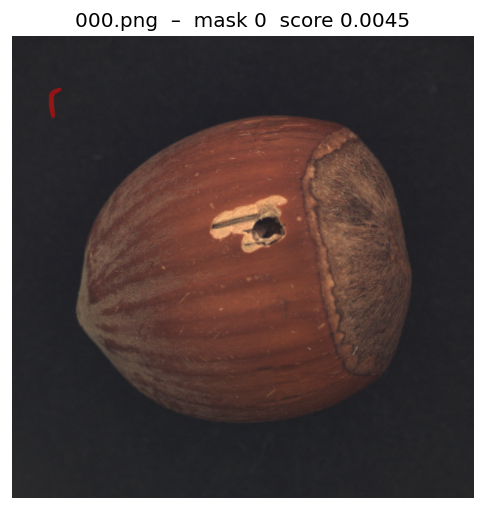

In [11]:
data = torch.load(TOK_FILE, map_location="cpu", weights_only=False)
mask_tok = data["mask_token"].to(DEVICE, model.dtype).unsqueeze(0)   
mask_list = data["mask"]                                             
M = mask_tok.size(1)

with torch.no_grad():
    m_emb = model.multi_modal_projector(mask_tok)                    

prompt = tok_img * M + " Is there any anomaly in the image?"
tok = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
t_emb = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

inp   = torch.cat([m_emb, t_emb], dim=1)
att_m = torch.cat([torch.ones(1, M, device=DEVICE, dtype=torch.long),
                   tok.attention_mask], dim=1)

with torch.no_grad():
    out = model(inputs_embeds=inp,
                attention_mask=att_m,
                output_attentions=True,
                output_hidden_states=True,
                return_dict=True)

att_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
score_A = att_avg[inp.size(1)-1, :M]                                 

h_pre  = m_emb.squeeze(0)
h_post = out.hidden_states[-1].squeeze(0)[:M]
anom_emb = model.get_input_embeddings()(
              torch.tensor(processor.tokenizer(" anomaly", add_special_tokens=False).input_ids,
                           device=DEVICE)).mean(0)

score_B = F.cosine_similarity(h_post, anom_emb, -1) - F.cosine_similarity(h_pre, anom_emb, -1)
raw     = ALPHA*score_A + (1-ALPHA)*score_B
raw     = raw - raw.min()                                            
best_i  = torch.argmax(raw).item()

print(f"\n>>> 선택된 anomaly mask index: {best_i}  score: {raw[best_i]:.4f}")

img_name = data["img_name"]              
rgb = np.array(Image.open(IMG_ROOT / img_name).convert("RGB"))
H,W = rgb.shape[:2]

mask_np = mask_list[best_i].astype(np.uint8)*255
mask_im = Image.fromarray(mask_np).resize((W,H), Image.NEAREST)
mask_bool = np.array(mask_im, dtype=bool)

overlay = rgb.astype(np.float32)
overlay[mask_bool] = 0.5*overlay[mask_bool] + 0.5*np.array([255,0,0])
overlay = overlay.astype(np.uint8)

plt.figure(figsize=(5,5), dpi=120)
plt.imshow(overlay); plt.axis("off")
plt.title(f"{img_name}  –  mask {best_i}  score {raw[best_i]:.4f}")
plt.show()

## ## Global Token + Mask Token

In [1]:
import torch, torch.nn.functional as F, numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

MASK_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/000_siglip_tokens.pt")
GLOB_PT = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole/good/000_global_token.pt")
IMG_DIR = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/test/hole")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
DEVICE   = "cuda" if torch.cuda.is_available() else "cpu"
ALPHA    = 0.5

In [ ]:
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model     = LlavaOnevisionForConditionalGeneration.from_pretrained(
               MODEL_ID, torch_dtype=torch.bfloat16,
               device_map="auto", low_cpu_mem_usage=True,
               trust_remote_code=True).eval()
tok_img = processor.tokenizer.additional_special_tokens[0]

In [ ]:
mask_dat = torch.load(MASK_PT, map_location="cpu", weights_only=False)
glob_tok = torch.load(GLOB_PT,  map_location="cpu", weights_only=False)["global_token"]

mask_tok = mask_dat["mask_token"]                  
full_tok = torch.cat([glob_tok.unsqueeze(0), mask_tok], dim=0)  
full_tok = full_tok.to(DEVICE, model.dtype).unsqueeze(0)        
M = full_tok.size(1) - 1                                        

with torch.no_grad():
    emb = model.multi_modal_projector(full_tok)  

prompt = tok_img * (M+1) + " Is there any anomaly in the image?"
tok = processor.tokenizer(prompt, return_tensors="pt").to(DEVICE)
t_emb = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

inp   = torch.cat([emb, t_emb], dim=1)
att_m = torch.cat([torch.ones(1, M+1, dtype=torch.long, device=DEVICE),
                   tok.attention_mask], dim=1)

with torch.no_grad():
    out = model(inputs_embeds=inp,
                attention_mask=att_m,
                output_attentions=True,
                output_hidden_states=True,
                return_dict=True)

>>> best mask idx = 1, score = 0.0204


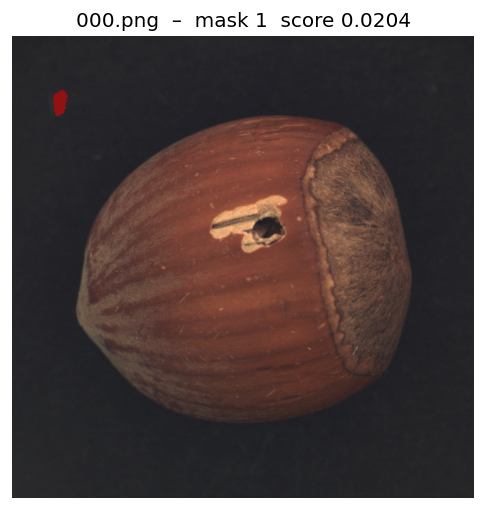

In [4]:
att_avg = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
sA = att_avg[inp.size(1)-1, 1:M+1]

h_pre  = emb.squeeze(0)[1:]
h_post = out.hidden_states[-1].squeeze(0)[1:M+1]

anom_emb = model.get_input_embeddings()(
             torch.tensor(processor.tokenizer(" anomaly", add_special_tokens=False).input_ids,
                          device=DEVICE)).mean(0)

sB = F.cosine_similarity(h_post, anom_emb, -1) - F.cosine_similarity(h_pre, anom_emb, -1)
scores = ALPHA*sA + (1-ALPHA)*sB
scores = scores - scores.min()
best_i = torch.argmax(scores).item()

print(f">>> best mask idx = {best_i}, score = {scores[best_i]:.4f}")

img = np.array(Image.open(IMG_DIR / mask_dat["img_name"]).convert("RGB"))
H,W = img.shape[:2]

msk = mask_dat["mask"][best_i].astype(np.uint8)*255
msk = np.array(Image.fromarray(msk).resize((W,H), Image.NEAREST), dtype=bool)

over = img.astype(np.float32)
over[msk] = 0.5*over[msk] + 0.5*np.array([255,0,0])
over = over.astype(np.uint8)

plt.figure(figsize=(5,5), dpi=120); plt.imshow(over); plt.axis("off")
plt.title(f"{mask_dat['img_name']}  –  mask {best_i}  score {scores[best_i]:.4f}")
plt.show()

# # P-AUROC

In [7]:
import torch, torch.nn.functional as F, numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration

DEV      = "cuda" if torch.cuda.is_available() else "cpu"
TOK_DIR  = Path("/home/s2behappy4/data/gyuhyeong/code/siglip_token_demo/hazelnut/hole")
GT_ROOT  = Path("/home/s2behappy4/data/gyuhyeong/dataset/MMAD/MVTec-AD/hazelnut/ground_truth/hole")
MODEL_ID = "llava-hf/llava-onevision-qwen2-7b-ov-hf"
ALPHA    = 0.5

In [ ]:
processor = AutoProcessor.from_pretrained(MODEL_ID, trust_remote_code=True)
model     = LlavaOnevisionForConditionalGeneration.from_pretrained(
               MODEL_ID, torch_dtype=torch.bfloat16,
               device_map="auto", low_cpu_mem_usage=True,
               trust_remote_code=True).eval()
tok_img = processor.tokenizer.additional_special_tokens[0]  

In [ ]:
def compute_scores(mask_tok):                      
    with torch.no_grad():
        m_emb = model.multi_modal_projector(mask_tok)              
    N = m_emb.size(1)

    prompt = tok_img * N + " Is there any anomaly in the image?"
    tok = processor.tokenizer(prompt, return_tensors="pt").to(DEV)
    t_emb = model.get_input_embeddings()(tok.input_ids).to(model.dtype)

    inp   = torch.cat([m_emb, t_emb], dim=1)
    att_m = torch.cat([torch.ones(1, N, device=DEV, dtype=torch.long),
                       tok.attention_mask], dim=1)
    with torch.no_grad():
        out = model(inputs_embeds=inp,
                    attention_mask=att_m,
                    output_attentions=True,
                    output_hidden_states=True,
                    return_dict=True)

    # Self-Attention
    a_mean = torch.stack([a.mean(1).squeeze(0) for a in out.attentions]).mean(0)
    sA = a_mean[inp.size(1)-1, :N]

    # Cos-Shift
    h_pre  = m_emb.squeeze(0)
    h_post = out.hidden_states[-1].squeeze(0)[:N]
    v_anom = model.get_input_embeddings()(
               torch.tensor(processor.tokenizer(" anomaly", add_special_tokens=False).input_ids,
                            device=DEV)).mean(0)
    sB = F.cosine_similarity(h_post, v_anom, -1) - F.cosine_similarity(h_pre, v_anom, -1)

    raw = ALPHA * sA + (1-ALPHA) * sB
    raw = torch.nan_to_num(raw, nan=0.0, posinf=0.0, neginf=0.0)    
    return (raw - raw.min()).cpu()                                 

def heatmap_from_masks(scores, masks, H, W):
    hmap = np.zeros((H, W), np.float32)
    for s, m in zip(scores, masks):
        hmap[m.astype(bool)] = np.maximum(hmap[m.astype(bool)], float(s))
    return hmap.ravel()

img_scores, img_labels, per_img_auc = [], [], {}
for pt in tqdm(sorted(TOK_DIR.glob("*_siglip_tokens.pt")), desc="eval", unit="img"):
    stem = pt.stem.split("_")[0]
    dat  = torch.load(pt, map_location="cpu", weights_only=False)

    m_tok = dat["mask_token"].to(DEV, model.dtype).unsqueeze(0)     
    scores = compute_scores(m_tok)                                  

    gt = Image.open(GT_ROOT / f"{stem}_mask.png").convert("L")
    W, H = gt.size
    heat = heatmap_from_masks(scores, dat["mask"], H, W)
    gt_b = (np.array(gt) > 127).astype(np.uint8).ravel()

    auc  = roc_auc_score(gt_b, heat)
    per_img_auc[stem] = auc

    img_scores.extend(heat); img_labels.extend(gt_b)

overall_auc = roc_auc_score(img_labels, img_scores)

print("\nPer-image P-AUROC")
for k,v in per_img_auc.items():
    print(f"{k}: {v:.4f}")
print(f"\nOverall P-AUROC (hole): {overall_auc:.4f}")